# 1. Import Required Packages

필요한 라이브러리와 유틸리티 함수들을 불러온다.

In [ ]:
!pip -q install torchmetrics

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

import torchvision
from torchvision import datasets
from torchvision import transforms

from torchmetrics import Accuracy

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.1 MB/s eta 0:00:00


In [ ]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu")
device

device(type='cuda')

# 2. Dataset Preparation and Visualization

데이터셋을 다운로드하고 랜덤 샘플을 시각화한다.

In [ ]:
mean = torch.tensor((0.4914, 0.4822, 0.4465))
std = torch.tensor((0.2023, 0.1994, 0.2010))

train_transform = transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean, std, inplace=True)
])

test_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean, std, inplace=True)
])

In [ ]:
train_dataset = datasets.CIFAR10(root="data",
                                 download=True,
                                 train=True,
                                 transform=train_transform)

test_dataset = datasets.CIFAR10(root="data",
                                download=True,
                                train=False,
                                transform=test_transform)

100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]


In [ ]:
img, label = train_dataset[0]
img.shape, label

(torch.Size([3, 32, 32]), 6)

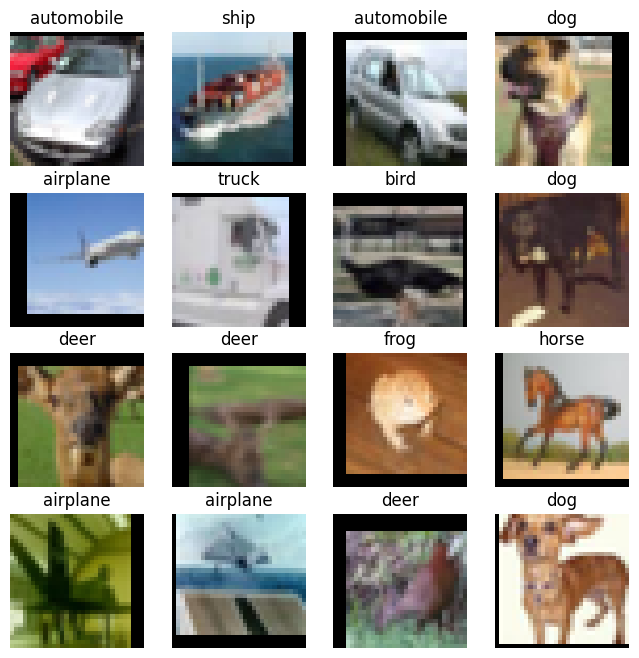

In [ ]:
def denormalize(img):
  return torch.clamp(img * std[:, None, None] + mean[:, None, None], min=0)

def plot_random_samples(dataset, n_rows=4, n_cols=4):
  n_samples = n_rows * n_cols
  sample_indices = np.random.choice(len(dataset), n_samples)

  imgs, labels = zip(*[dataset[i] for i in sample_indices])

  plt.figure(figsize=(8, 8))

  for i in range(n_samples):
    img = denormalize(imgs[i])

    plt.subplot(n_rows, n_cols, i + 1)

    plt.imshow(img.permute(1, 2, 0))
    plt.title(dataset.classes[labels[i]])
    plt.axis(False)

plot_random_samples(train_dataset)

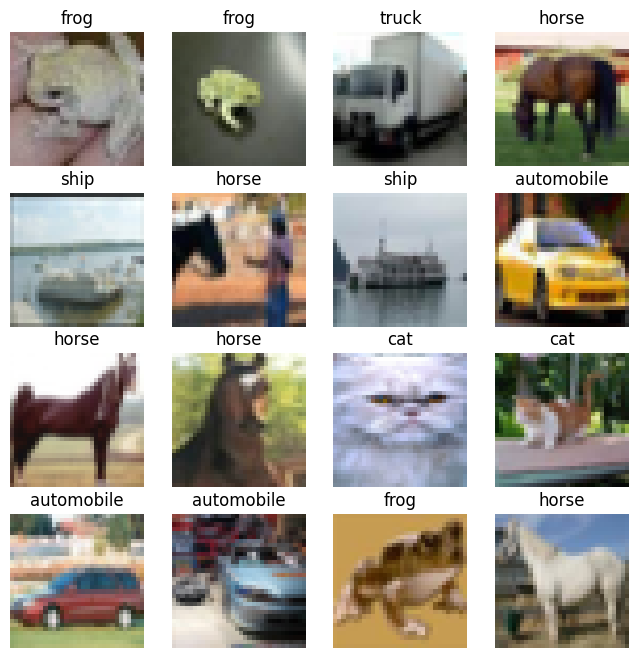

In [ ]:
plot_random_samples(test_dataset)

# 3. Training and Evaluation Functions

모델 훈련과 검증을 위한 기본 함수를 정의한다.

In [ ]:
def to_device(*args, device=device):
  return [arg.to(device, non_blocking=True) for arg in args]

def train_epoch(dataloader, model, criterion, optimizer, accuracy):
  model.train()

  train_loss, train_acc = 0, 0

  for X, y in tqdm(dataloader, desc="Training", leave=False):
    X, y = to_device(X, y)

    logits = model(X)

    loss = criterion(logits, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      probs = torch.softmax(logits, dim=1)
      preds = probs.argmax(dim=1)

      train_loss += loss.cpu().item()
      train_acc += accuracy(preds, y).cpu().item()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

def validate_epoch(dataloader, model, criterion, accuracy):
  model.eval()

  val_loss, val_acc = 0, 0

  with torch.no_grad():
    for X, y in tqdm(dataloader, desc="Validate", leave=False):
      X, y = to_device(X, y)

      logits = model(X)
      probs = torch.softmax(logits, dim=1)
      preds = probs.argmax(dim=1)

      loss = criterion(logits, y)

      val_loss += loss.cpu().item()
      val_acc += accuracy(preds, y).cpu().item()

  val_loss /= len(dataloader)
  val_acc /= len(dataloader)

  return val_loss, val_acc

In [ ]:
def train(n_epochs,
          train_dataloader,
          test_dataloader,
          model,
          criterion,
          optimizer,
          scheduler,
          accuracy):

  train_losses, train_accs = [], []
  val_losses, val_accs = [], []

  for epoch in tqdm(range(1, n_epochs + 1), desc="Epoch", leave=False):
    train_loss, train_acc = train_epoch(train_dataloader, model, criterion, optimizer, accuracy)
    val_loss, val_acc = validate_epoch(test_dataloader, model, criterion, accuracy)

    if scheduler is not None:
      scheduler.step(val_acc)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch: {epoch: 4d} | Train loss: {train_loss: .5f} | Train acc: {train_acc: .5f} | Val loss: {val_loss: .5f} | Val acc: {val_acc: .5f}")

  return train_losses, train_accs, val_losses, val_accs

In [ ]:
def plot_train_log(n_epochs, train_losses, train_accs, val_losses, val_accs):
  epochs = np.arange(1, n_epochs + 1)

  plt.figure(figsize=(15, 5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_losses, label="train loss")
  plt.plot(epochs, val_losses, label="val loss")
  plt.title("Loss")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_accs, label="train acc")
  plt.plot(epochs, val_accs, label="val acc")
  plt.title("Acc")
  plt.legend()

# 4. Model Experiments and Architecture Tuning

다양한 모델 구조를 실험하며 성능 목표인 정확도 0.8 이상을 달성하도록 개선한다.

## TinyVGGCIFAR10_v0

In [ ]:
class TinyVGGCIFAR10_v0(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(16, 16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(2048, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(256, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(256, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

Epoch:    1 | Train loss:  1.93715 | Train acc:  0.26887 | Val loss:  1.59959 | Val acc:  0.41384


Epoch:    2 | Train loss:  1.57478 | Train acc:  0.41715 | Val loss:  1.32603 | Val acc:  0.52756


Epoch:    3 | Train loss:  1.38938 | Train acc:  0.49540 | Val loss:  1.12551 | Val acc:  0.59864


Epoch:    4 | Train loss:  1.28470 | Train acc:  0.54011 | Val loss:  1.06070 | Val acc:  0.62500


Epoch:    5 | Train loss:  1.20314 | Train acc:  0.57440 | Val loss:  0.96063 | Val acc:  0.65984


Epoch:    6 | Train loss:  1.16763 | Train acc:  0.59179 | Val loss:  0.98135 | Val acc:  0.65176


Epoch:    7 | Train loss:  1.13641 | Train acc:  0.60421 | Val loss:  0.90495 | Val acc:  0.68271


Epoch:    8 | Train loss:  1.10961 | Train acc:  0.61452 | Val loss:  0.94092 | Val acc:  0.66773


Epoch:    9 | Train loss:  1.10890 | Train acc:  0.61786 | Val loss:  0.90762 | Val acc:  0.68540


Epoch:   10 | Train loss:  1.09771 | Train acc:  0.62082 | Val loss:  0.92977 | Val acc:  0.67472


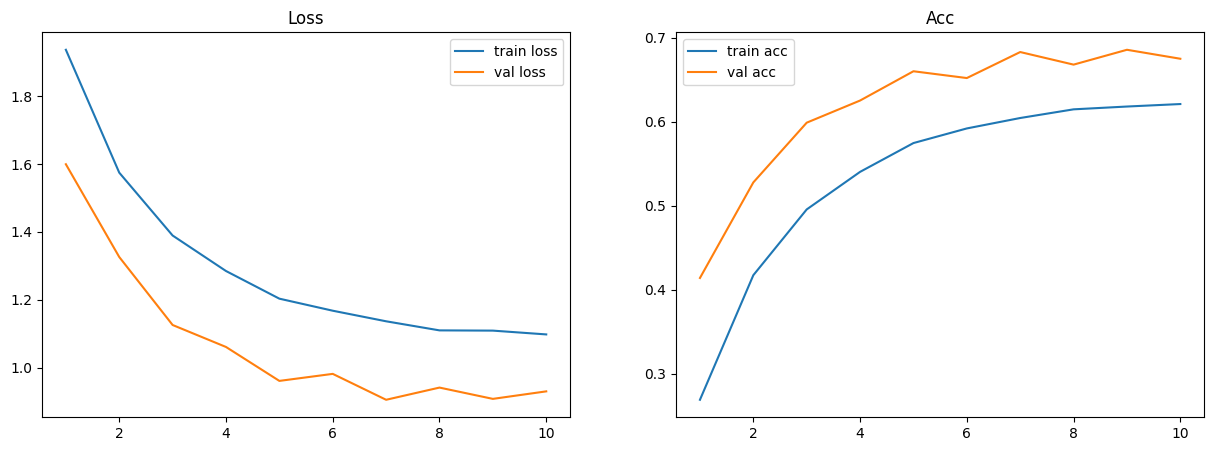

In [ ]:
batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

model = TinyVGGCIFAR10_v0().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(),
                          momentum=0.9,
                          lr=0.01)

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

n_epochs = 10
logs = train(n_epochs=n_epochs,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             model=model,
             criterion=criterion,
             optimizer=optimizer,
             scheduler=None,
             accuracy=accuracy)

plot_train_log(n_epochs, *logs)

- Train Accuracy가 더 높다 등의 오버피팅 패턴이 발견되지 않음.

- Train/Val Accuracy 모두 0.6-0.65 수준에서 수렴, Loss도 수렴.

- 따라서 모델이 수렴한 상태라 판단 -> 모델의 표현력이 부족한 언더피팅

## TinyVGGCIFAR10_v1

features에 VGGBlock 추가해 모델의 표현력 높이고자 시도함.

In [ ]:
class VGGBlock(nn.Module):
  def __init__(self, in_channels, out_channels, n_convs):
    super().__init__()

    layers = []

    for _ in range(n_convs):
      layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
      layers.append(nn.ReLU(inplace=True))
      in_channels = out_channels

    layers.append(nn.MaxPool2d(kernel_size=2))

    self.block = nn.Sequential(*layers)

  def forward(self, x):
    return self.block(x)

In [ ]:
class TinyVGGCIFAR10_v1(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
        VGGBlock(3, 16, n_convs=2),
        VGGBlock(16, 32, n_convs=2),
        VGGBlock(32, 64, n_convs=2),
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1024, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(256, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(256, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

Epoch:    1 | Train loss:  2.08285 | Train acc:  0.20849 | Val loss:  1.80932 | Val acc:  0.32907


Epoch:    2 | Train loss:  1.71943 | Train acc:  0.34835 | Val loss:  1.55596 | Val acc:  0.43021


Epoch:    3 | Train loss:  1.47768 | Train acc:  0.45963 | Val loss:  1.33731 | Val acc:  0.50899


Epoch:    4 | Train loss:  1.30890 | Train acc:  0.52881 | Val loss:  1.18651 | Val acc:  0.57548


Epoch:    5 | Train loss:  1.20261 | Train acc:  0.57560 | Val loss:  1.00581 | Val acc:  0.64137


Epoch:    6 | Train loss:  1.13295 | Train acc:  0.60851 | Val loss:  0.95421 | Val acc:  0.66344


Epoch:    7 | Train loss:  1.09030 | Train acc:  0.62352 | Val loss:  1.00120 | Val acc:  0.65216


Epoch:    8 | Train loss:  1.06344 | Train acc:  0.63704 | Val loss:  0.89547 | Val acc:  0.69688


Epoch:    9 | Train loss:  1.04466 | Train acc:  0.64533 | Val loss:  0.91715 | Val acc:  0.68171


Epoch:   10 | Train loss:  1.03845 | Train acc:  0.64853 | Val loss:  0.93573 | Val acc:  0.67901


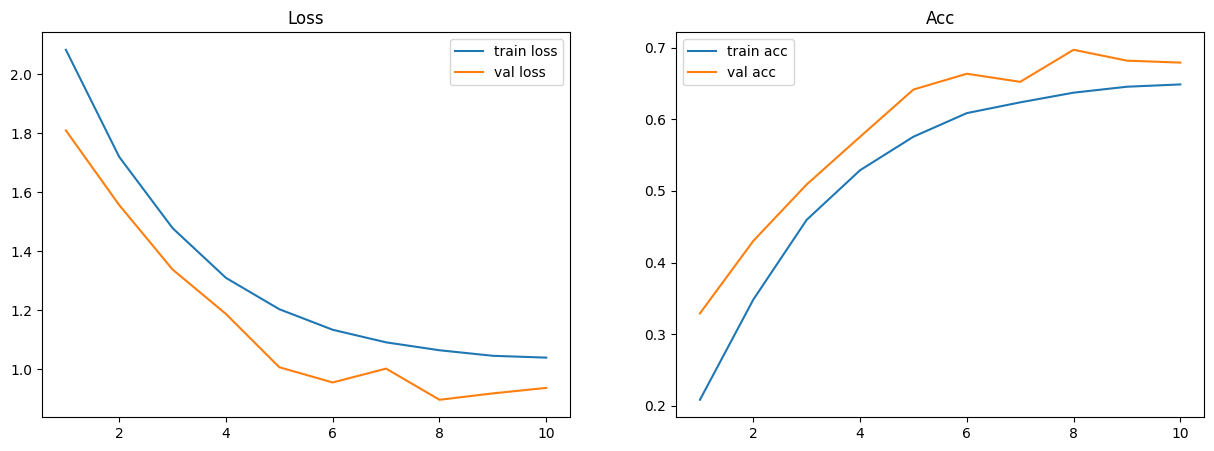

In [ ]:
batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

model = TinyVGGCIFAR10_v1().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(),
                          momentum=0.9,
                          lr=0.01)

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

n_epochs = 10
logs = train(n_epochs=n_epochs,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             model=model,
             criterion=criterion,
             optimizer=optimizer,
             scheduler=None,
             accuracy=accuracy)

plot_train_log(n_epochs, *logs)

## TinyVGGCIFAR10_v2

features에 VGGBlock 추가해 모델의 표현력 높이고자 시도함.

In [ ]:
class TinyVGGCIFAR10_v2(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
        VGGBlock(3, 16, n_convs=2),
        VGGBlock(16, 32, n_convs=2),
        VGGBlock(32, 64, n_convs=2),
        VGGBlock(64, 128, n_convs=2),
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(256, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(256, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

Epoch:    1 | Train loss:  2.30362 | Train acc:  0.10129 | Val loss:  2.30298 | Val acc:  0.10014


Epoch:    2 | Train loss:  2.22701 | Train acc:  0.14093 | Val loss:  1.95928 | Val acc:  0.24461


Epoch:    3 | Train loss:  1.88730 | Train acc:  0.26518 | Val loss:  1.66519 | Val acc:  0.35593


Epoch:    4 | Train loss:  1.67938 | Train acc:  0.35903 | Val loss:  1.47754 | Val acc:  0.44060


Epoch:    5 | Train loss:  1.51174 | Train acc:  0.44168 | Val loss:  1.30338 | Val acc:  0.52546


Epoch:    6 | Train loss:  1.34445 | Train acc:  0.51739 | Val loss:  1.13542 | Val acc:  0.58916


Epoch:    7 | Train loss:  1.22918 | Train acc:  0.56670 | Val loss:  1.07502 | Val acc:  0.61671


Epoch:    8 | Train loss:  1.13915 | Train acc:  0.60347 | Val loss:  1.06324 | Val acc:  0.62181


Epoch:    9 | Train loss:  1.07545 | Train acc:  0.62864 | Val loss:  1.06493 | Val acc:  0.62660


Epoch:   10 | Train loss:  1.02615 | Train acc:  0.65205 | Val loss:  0.96294 | Val acc:  0.67292


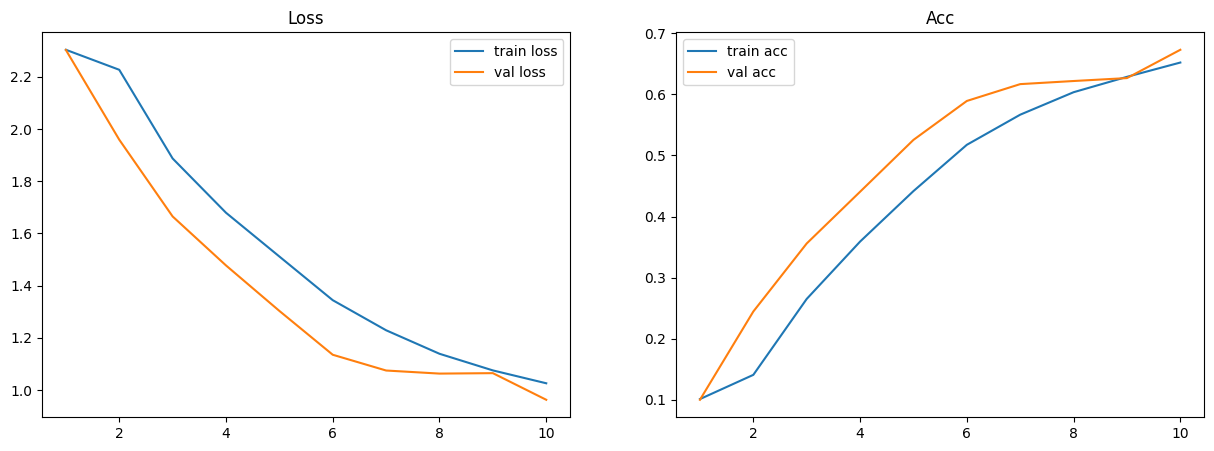

In [ ]:
batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

model = TinyVGGCIFAR10_v2().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(),
                            momentum=0.9,
                            lr=0.01)

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

n_epochs = 10
logs = train(n_epochs=n_epochs,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             model=model,
             criterion=criterion,
             optimizer=optimizer,
             scheduler=None,
             accuracy=accuracy)

plot_train_log(n_epochs, *logs)

Epoch:    1 | Train loss:  1.00350 | Train acc:  0.66491 | Val loss:  0.91625 | Val acc:  0.69788


Epoch:    2 | Train loss:  0.97190 | Train acc:  0.67588 | Val loss:  0.92157 | Val acc:  0.68121


Epoch:    3 | Train loss:  0.95603 | Train acc:  0.68650 | Val loss:  0.82441 | Val acc:  0.71456


Epoch:    4 | Train loss:  0.94839 | Train acc:  0.68572 | Val loss:  0.94749 | Val acc:  0.69279


Epoch:    5 | Train loss:  0.95664 | Train acc:  0.68756 | Val loss:  0.90336 | Val acc:  0.70008


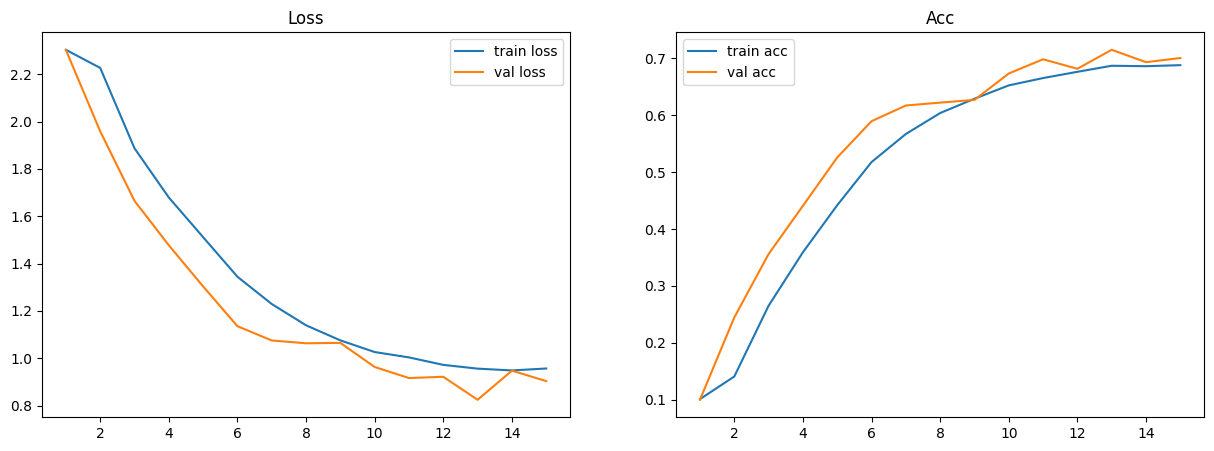

In [ ]:
tail = train(n_epochs=5,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             model=model,
             criterion=criterion,
             optimizer=optimizer,
             scheduler=None,
             accuracy=accuracy)

plot_train_log(15, *[log + t for log, t in zip(logs, tail)])

## TinyVGGCIFAR10_v3

features에 VGGBlock 추가해 모델의 표현력 높이고자 시도함.

In [ ]:
class TinyVGGCIFAR10_v3(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
        VGGBlock(3, 16, n_convs=2),
        VGGBlock(16, 32, n_convs=2),
        VGGBlock(32, 64, n_convs=2),
        VGGBlock(64, 128, n_convs=2),
        VGGBlock(128, 256, n_convs=2),
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(256, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(256, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(256, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

In [ ]:
batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

model = TinyVGGCIFAR10_v3().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(),
                            momentum=0.9,
                            lr=0.01)

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

n_epochs = 10
logs = train(n_epochs=n_epochs,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             model=model,
             criterion=criterion,
             optimizer=optimizer,
             scheduler=None,
             accuracy=accuracy)

plot_train_log(n_epochs, *logs)

Epoch:    1 | Train loss:  2.30373 | Train acc:  0.10293 | Val loss:  2.30311 | Val acc:  0.10014


Epoch:    2 | Train loss:  2.30355 | Train acc:  0.10021 | Val loss:  2.30284 | Val acc:  0.10014


Epoch:    3 | Train loss:  2.30344 | Train acc:  0.10005 | Val loss:  2.30270 | Val acc:  0.10014


KeyboardInterrupt: 

Loss가 전혀 감소하지 않고, 랜덤 예측과 비슷한 정확도를 보임.

학습이 안되는 상태이며 너무 깊어진 구조로 인한 Gradient vanishing이 의심됨.

## TinyVGGCIFAR10_v4

VGGBlock에서 Conv layer의 출력 이후에 BatchNorm 적용, Gradient vanishing 문제에 대응 시도함.

In [ ]:
class VGGBNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, n_convs):
    super().__init__()

    layers = []

    for _ in range(n_convs):
      layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
      layers.append(nn.BatchNorm2d(out_channels))
      layers.append(nn.ReLU(inplace=True))
      in_channels = out_channels

    layers.append(nn.MaxPool2d(kernel_size=2))

    self.block = nn.Sequential(*layers)

  def forward(self, x):
    return self.block(x)

In [ ]:
class TinyVGGCIFAR10_v4(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
        VGGBNBlock(3, 16, n_convs=2),
        VGGBNBlock(16, 32, n_convs=2),
        VGGBNBlock(32, 64, n_convs=2),
        VGGBNBlock(64, 128, n_convs=2),
        VGGBNBlock(128, 256, n_convs=2),
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(256, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(256, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(256, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

Epoch:    1 | Train loss:  1.77778 | Train acc:  0.32252 | Val loss:  1.40048 | Val acc:  0.47634


Epoch:    2 | Train loss:  1.39774 | Train acc:  0.50678 | Val loss:  1.12135 | Val acc:  0.59844


Epoch:    3 | Train loss:  1.17130 | Train acc:  0.60091 | Val loss:  0.96394 | Val acc:  0.66224


Epoch:    4 | Train loss:  1.03372 | Train acc:  0.65491 | Val loss:  0.83843 | Val acc:  0.71066


Epoch:    5 | Train loss:  0.93269 | Train acc:  0.69374 | Val loss:  0.78228 | Val acc:  0.73423


Epoch:    6 | Train loss:  0.85777 | Train acc:  0.71829 | Val loss:  0.76092 | Val acc:  0.74631


Epoch:    7 | Train loss:  0.80459 | Train acc:  0.73774 | Val loss:  0.69136 | Val acc:  0.76508


Epoch:    8 | Train loss:  0.75774 | Train acc:  0.75252 | Val loss:  0.64170 | Val acc:  0.78265


Epoch:    9 | Train loss:  0.72103 | Train acc:  0.76496 | Val loss:  0.70212 | Val acc:  0.76468


Epoch:   10 | Train loss:  0.68229 | Train acc:  0.77763 | Val loss:  0.64780 | Val acc:  0.78075


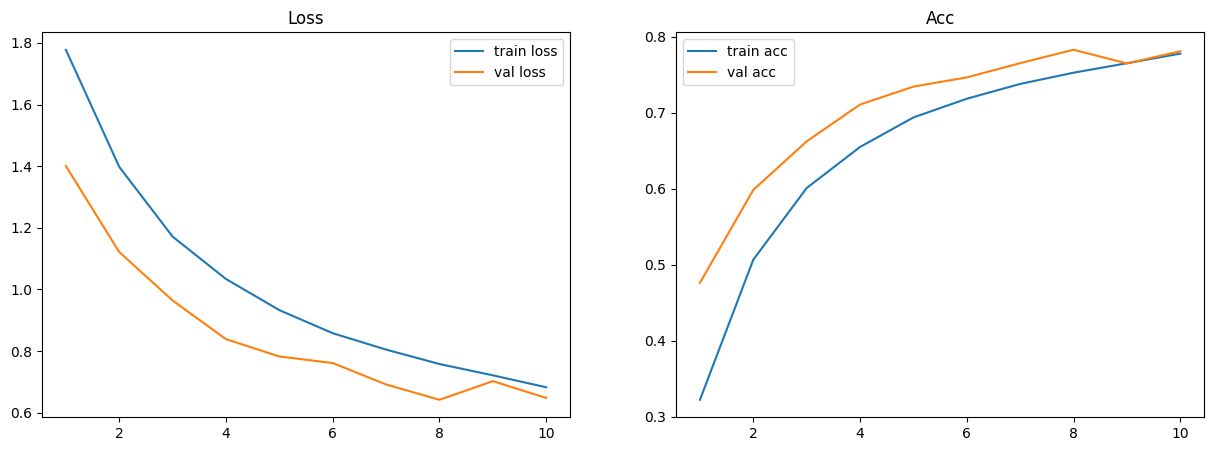

In [ ]:
batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

model = TinyVGGCIFAR10_v4().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(),
                            momentum=0.9,
                            lr=0.01)

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

n_epochs = 10
logs = train(n_epochs=n_epochs,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             model=model,
             criterion=criterion,
             optimizer=optimizer,
             scheduler=None,
             accuracy=accuracy)

plot_train_log(n_epochs, *logs)

In [ ]:
tail = train(n_epochs=3,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             model=model,
             criterion=criterion,
             optimizer=optimizer,
             scheduler=None,
             accuracy=accuracy)

Epoch:    1 | Train loss:  0.66407 | Train acc:  0.78509 | Val loss:  0.61625 | Val acc:  0.79692


Epoch:    2 | Train loss:  0.62761 | Train acc:  0.79726 | Val loss:  0.56630 | Val acc:  0.80761


Epoch:    3 | Train loss:  0.61159 | Train acc:  0.80014 | Val loss:  0.58413 | Val acc:  0.80212


In [ ]:
torch.save({"model_state_dict": model.state_dict(),
            "best_val_acc": 0.80761},
           "TinyVGGCIFAR10_v4_chk_0.pth")

# 5. Load Saved Model and Final Evaluation

최적의 모델을 불러오고 테스트셋에서 성능을 확인한다.

In [ ]:
chk = torch.load("TinyVGGCIFAR10_v4_chk_0.pth")

model = TinyVGGCIFAR10_v4().to(device)
model.load_state_dict(chk["model_state_dict"])

<All keys matched successfully>

In [ ]:
batch_size = 32

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

criterion = nn.CrossEntropyLoss()

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

_, val_acc = validate_epoch(test_dataloader, model, criterion, accuracy)

val_acc

0.8021166134185304

In [ ]:
def plot_random_preds(dataset, model, n_rows=4, n_cols=4):
  n_samples = n_rows * n_cols

  sample_indices = np.random.choice(len(dataset), n_samples)
  imgs, labels = zip(*[dataset[i] for i in sample_indices])

  model.eval()

  with torch.no_grad():
    X = torch.stack(imgs, dim=0).to(device)
    y = torch.tensor(labels).to(device)

    logits = model(X)
    probs = torch.softmax(logits, dim=1)
    preds = probs.argmax(dim=1)

    corrects = (preds == y)

  plt.figure(figsize=(13, 13))

  for i in range(n_samples):
    img = denormalize(imgs[i]).permute(1, 2, 0)
    pred_class = dataset.classes[preds[i]]
    true_class = dataset.classes[labels[i]]

    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {pred_class} | True: {true_class}", c = 'g' if corrects[i] else 'r')
    plt.axis(False)

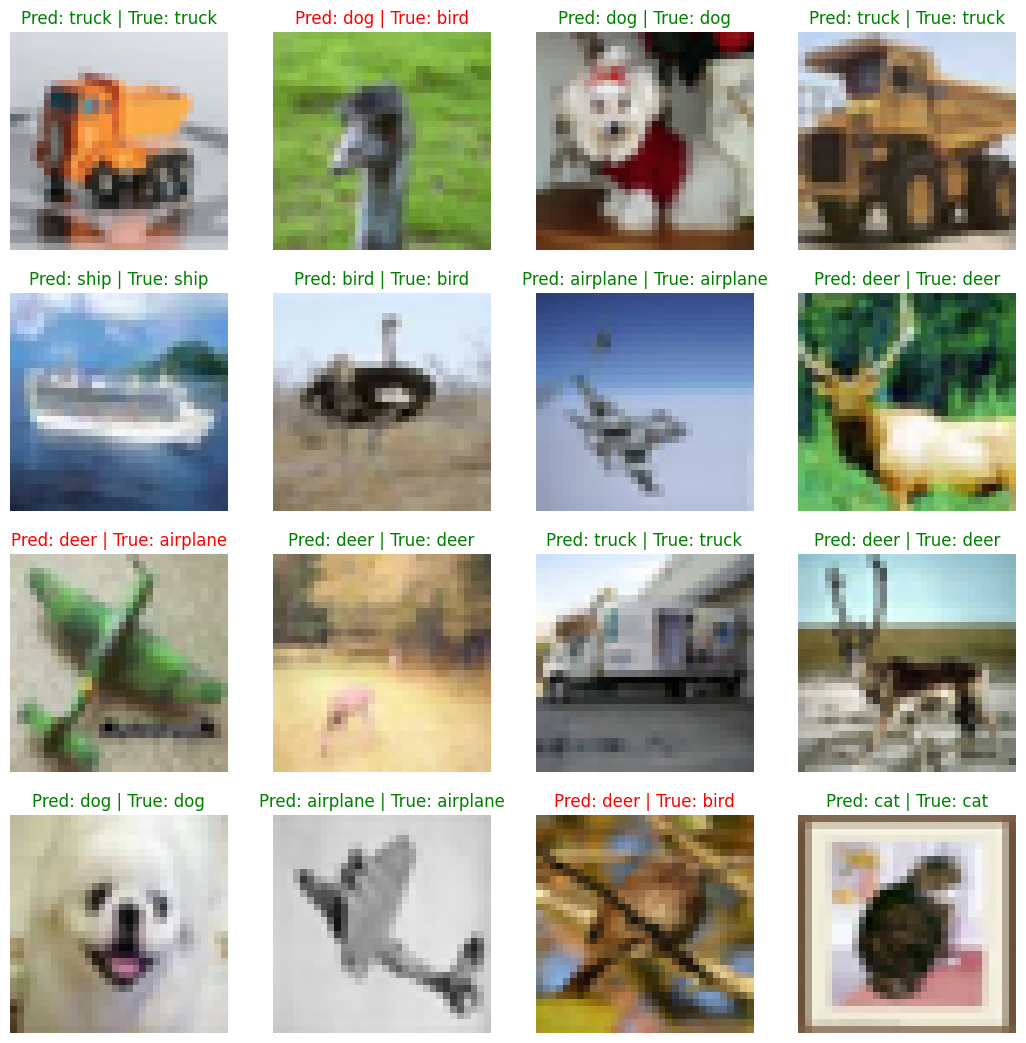

In [ ]:
plot_random_preds(test_dataset, model)